# Clasificador de reseñas

## Imports necesariosimport pandas as pd

In [1]:
import pandas as pd
import os
import multiprocess as mp
import copy
import torch
import gc
import numpy as np
from transformers import XLMRobertaForSequenceClassification, XLMRobertaTokenizerFast, Trainer, TrainingArguments, RobertaConfig, EarlyStoppingCallback
from datasets import Dataset, DatasetDict, concatenate_datasets
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_recall_fscore_support

/srv/home/tfg24_01/ibmalles/.local/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Selecionar la mejor GPU

In [2]:
import os
import torch
import subprocess

def get_best_gpu():
    result = subprocess.run(['nvidia-smi', '--query-gpu=memory.free', '--format=csv,nounits,noheader'],
                            stdout=subprocess.PIPE, text=True)
    free_mem = [int(x) for x in result.stdout.strip().split("\n")]
    best_gpu = free_mem.index(max(free_mem))
    return best_gpu

best_gpu = get_best_gpu()
os.environ["CUDA_VISIBLE_DEVICES"] = str(best_gpu)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando GPU: {torch.cuda.get_device_name(device)}")


Usando GPU: NVIDIA GeForce RTX 3080


## Configurar el multiprocesamiento

Se hace para que sea compatible con CUDA

In [3]:
mp.set_start_method("spawn", force = True)

## Importar los datos

### Funciones que se van a utilizar

Función para exportar un txt a un dataframe 

In [4]:
def importFromTxtToDF(source, label):
    with open(source, 'r', encoding="utf-8") as file:
        #Generate a list with all the reviews
        targetList = [line.strip() for line in file]

    targetDF = pd.DataFrame(targetList, columns=['review'])

    targetDF["label"] = label
    
    return targetDF

In [5]:
def dataToDataFrames(invalidReviewsPath, validReviewsPath):
    
    #Export data to dataframes
    invalidReviewsDF = importFromTxtToDF(invalidReviewsPath, "n") # n is the label of the invalid reviews
    validReviewsDF = importFromTxtToDF(validReviewsPath, "v") # v is the label of the valid reviews
    
    #Combine dataframes
    return pd.concat([invalidReviewsDF, validReviewsDF], ignore_index = True)

Función que divide el conjunto de datos en entrenamiento, validación y test. Además proporciona una lista de índices, correspondientes al conjunto de datos original, de los datos de test y validación

In [6]:
def trainTestValidationSplit(dataset, trainPctg = 0.8):

    #Add a column with the original index
    dataset = dataset.add_column("originalIdx", list(range(len(dataset))))

    #Divide the dataset
    datasetSplit = dataset.train_test_split(test_size = 1 - trainPctg, seed = 54)
    validationTestSplit = datasetSplit["test"].train_test_split(test_size = 0.5, seed = 54)

    #Generate the datasets
    trainDataset = datasetSplit["train"]
    validationDataset = validationTestSplit["train"]
    testDataset = validationTestSplit["test"]

    #Extract the list of indexes corresponding to the test and validation data
    testIdxs = testDataset["originalIdx"]
    validationIdxs = validationDataset["originalIdx"]

    #Dataset dictionary
    datasetDict = DatasetDict({
        "train" : trainDataset,
        "validation" : validationDataset,
        "test" : testDataset
        })

    #Remove the originalIdx column from all datasets in the dictionary
    datasetDict = datasetDict.map(lambda x: x, remove_columns = ["originalIdx"])

    #Shufle the datasets
    for split in datasetDict.keys():
        datasetDict[split] = datasetDict[split].shuffle()

    return datasetDict, validationIdxs, testIdxs

Función que va a recibir un dataframe de datos sintéticos, el conjunto de datos originales (separado en entrenamiento validación y test), la lista de índices de validación y la lista de índices de test y va a añadir los elementos correspondientes de validación y test al conjunto de datos originales y va a devolver un dataset con esas filas eliminadas. Además se van a poner las etiquetas a numéricas

In [7]:
def formatDatasets(mainDataDict, augmentedDF, validationIdxs, testIdxs):

    augmentedDF['label'] = augmentedDF['label'].map({'v': 1, 'n': 0})

    #Extract the validation and test rows
    deletedRowsValidationDF = augmentedDF.iloc[validationIdxs].copy()
    deletedRowsTestDF = augmentedDF.iloc[testIdxs].copy()

    #Combine the list of indexes
    idxsToDelete = validationIdxs + testIdxs

    #Delete the rows
    augmentedDF = augmentedDF.drop(augmentedDF.index[idxsToDelete])

    #Add the extracted rows to the datadict
    augmentedValidationDataset = Dataset.from_pandas(deletedRowsValidationDF, preserve_index = False)
    augmentedTestDataset = Dataset.from_pandas(deletedRowsTestDF, preserve_index = False)

    mainDataDict["validation"] = concatenate_datasets([mainDataDict["validation"], augmentedValidationDataset])
    mainDataDict["test"] = concatenate_datasets([mainDataDict["test"], augmentedTestDataset])

    return mainDataDict, augmentedDF

### Datos originales

Con datos originales nos referimos a aquellos que no han sido generados usando técnicas de aumento de datos.

In [8]:
originalInvalidReviewsPath = "../1. Data/4. Labeled Reviews/2. Without Emojis/InvalidReviews.txt"
originalValidReviewsPath = "../1. Data/4. Labeled Reviews/2. Without Emojis/ValidReviews.txt"

originalDF = dataToDataFrames(originalInvalidReviewsPath, originalValidReviewsPath)

Se muestran los datos

In [9]:
originalDF.head()

,review,label
0,"""He vivido 35 años en el barrio y reconozco qu...",n
1,"""localización con muchos bares interesantes""",n
2,"""…""",n
3,"""Muy rica comida..""",n
4,"""Estación del.metro""",n


Número de elementos de cada clase

In [10]:
originalDF["label"].value_counts()

label
v    1943
n    1291
Name: count, dtype: int64

Para que las clases sean compatibles con el entrenamiento, se va a hacer que la columna label sea numérica: n = 0 y v = 1

In [11]:
originalDF['label'] = originalDF['label'].map({'v': 1, 'n': 0})

In [12]:
originalDF.head()

,review,label
0,"""He vivido 35 años en el barrio y reconozco qu...",0
1,"""localización con muchos bares interesantes""",0
2,"""…""",0
3,"""Muy rica comida..""",0
4,"""Estación del.metro""",0


Convertir el conjunto de datos en un dataset de HuggingFace

In [13]:
originalDataset = Dataset.from_pandas(originalDF)

print(originalDataset)

Dataset({
    features: ['review', 'label'],
    num_rows: 3234
})


Dividir el conjunto de datos en entrenamiento, validación y test. Y extraer los índices de los datos en el conjunto de validación y test.

In [14]:
originalDataDict, validationIdxs, testIdxs = trainTestValidationSplit(originalDataset)

print(originalDataDict)

Map: 100%|██████████| 324/324 [00:00<00:00, 16855.25 examples/s]

DatasetDict({
    train: Dataset({
        features: ['review', 'label'],
        num_rows: 2587
    })
    validation: Dataset({
        features: ['review', 'label'],
        num_rows: 323
    })
    test: Dataset({
        features: ['review', 'label'],
        num_rows: 324
    })
})


Filas que no se deberán incluir en los conjuntos de datos sintéticos

In [15]:
validationIdxs

[2016,
 3062,
 574,
 528,
 1425,
 2131,
 2954,
 1011,
 332,
 370,
 3133,
 1734,
 1541,
 405,
 1457,
 1780,
 1116,
 1943,
 7,
 647,
 2901,
 1371,
 1614,
 226,
 938,
 879,
 161,
 2455,
 1364,
 2924,
 2350,
 2091,
 1577,
 613,
 2432,
 1035,
 2569,
 414,
 2471,
 1178,
 2867,
 2547,
 84,
 1520,
 2107,
 1081,
 1760,
 2967,
 2909,
 54,
 814,
 2566,
 1084,
 1753,
 1472,
 1930,
 2435,
 1998,
 1409,
 591,
 1162,
 520,
 1227,
 630,
 2096,
 1028,
 618,
 436,
 74,
 1401,
 2508,
 3045,
 823,
 800,
 1817,
 2784,
 1608,
 2305,
 1346,
 2103,
 991,
 1745,
 2354,
 966,
 1308,
 2743,
 2261,
 190,
 3110,
 3195,
 768,
 1807,
 2014,
 2703,
 2864,
 1828,
 2704,
 20,
 2061,
 1684,
 1925,
 2218,
 2494,
 3042,
 2384,
 1626,
 1070,
 2021,
 2128,
 1176,
 1913,
 2739,
 1290,
 2980,
 2726,
 2208,
 2048,
 424,
 1637,
 837,
 2763,
 705,
 1330,
 915,
 1126,
 812,
 1154,
 1718,
 860,
 138,
 944,
 2306,
 2643,
 2918,
 2200,
 495,
 2854,
 3151,
 3014,
 305,
 2488,
 3091,
 1451,
 2034,
 1640,
 698,
 1517,
 2890,
 1672,
 17

In [16]:
testIdxs

[949,
 2167,
 1839,
 2085,
 3031,
 1546,
 1768,
 2835,
 2826,
 2355,
 3095,
 2082,
 3048,
 2644,
 207,
 2876,
 700,
 1829,
 1053,
 1957,
 372,
 636,
 1009,
 3135,
 1630,
 345,
 748,
 1740,
 503,
 693,
 1535,
 2779,
 569,
 2731,
 1667,
 842,
 877,
 1320,
 3200,
 896,
 1522,
 1504,
 1800,
 173,
 2348,
 2875,
 1657,
 716,
 2887,
 2406,
 14,
 513,
 2681,
 2840,
 1844,
 874,
 3201,
 2599,
 617,
 1600,
 474,
 1043,
 773,
 872,
 2852,
 839,
 1635,
 2517,
 2994,
 209,
 1528,
 2565,
 1304,
 1414,
 2427,
 2711,
 832,
 2199,
 2401,
 2878,
 1423,
 6,
 1019,
 446,
 1565,
 958,
 554,
 444,
 2150,
 2860,
 3164,
 1107,
 2201,
 3156,
 927,
 2751,
 1358,
 2136,
 3114,
 2785,
 510,
 99,
 2922,
 48,
 2839,
 694,
 1523,
 2225,
 1144,
 2204,
 1681,
 2147,
 2055,
 2158,
 1861,
 1502,
 1490,
 1344,
 1083,
 2724,
 2771,
 1691,
 124,
 1905,
 2358,
 1743,
 1134,
 1331,
 1582,
 1155,
 686,
 856,
 2830,
 2562,
 1029,
 682,
 2512,
 992,
 401,
 1566,
 1225,
 1674,
 2987,
 2651,
 422,
 1138,
 1369,
 1076,
 2603,
 303

### Datos sintéticos

Estos datos son aquellos que se han generado mediante las técnicas de aumento de datos

#### Retrotraducción

Se importan los datos eliminando aquellas filas que se vayan a utilizar para entrear y validar en el conjunto original de datos

In [17]:
backtranslationInvalidReviewsPath = "1. Data Augmentation/1. Back Translation/3. Augmented Data/InvalidBackTranslationData.txt"
backtranslationValidReviewsPath = "1. Data Augmentation/1. Back Translation/3. Augmented Data/ValidBackTranslationData.txt"

#Import data
bactranslationDF = dataToDataFrames(backtranslationInvalidReviewsPath, backtranslationValidReviewsPath)

#Format the datadict and the dataframe
mainDataDict, bactranslationDF = formatDatasets(originalDataDict, bactranslationDF, validationIdxs, testIdxs)

Se muestran los datos

In [18]:
bactranslationDF.head()

,review,label
0,“Vivo en esta zona desde hace 35 años y recono...,0
1,"""Ubicación con muchos bares interesantes""",0
2,"""…""",0
3,"""Es una comida muy deliciosa"".",0
4,"""Estación de metro""",0


Número de elementos en cada clase

In [19]:
bactranslationDF["label"].value_counts()

label
1    1543
0    1044
Name: count, dtype: int64

#### Modelos de lenguaje preentreandos

Se importan los datos eliminando aquellas filas que se vayan a utilizar para entrear y validar en el conjunto original de datos

In [20]:
pretrainedNLPInvalidReviewsPath = "1. Data Augmentation/2. Pretrained NLP/2. Augmented Data/InvalidGPT4oMiniData.txt"
pretrainedNLPValidReviewsPath = "1. Data Augmentation/2. Pretrained NLP/2. Augmented Data/ValidGPT4oMiniData.txt"

#Import data
pretrainedNLPDF = dataToDataFrames(pretrainedNLPInvalidReviewsPath, pretrainedNLPValidReviewsPath)

#Format the datadict and the dataframe
mainDataDict, pretrainedNLPDF = formatDatasets(mainDataDict, pretrainedNLPDF, validationIdxs, testIdxs)

Se muestran los datos

In [21]:
pretrainedNLPDF.head()

,review,label
0,"""""Después de haber pasado 35 años en este veci...",0
1,"""""zona con una gran cantidad de bares atractiv...",0
2,"""Parece que no has proporcionado un texto para...",0
3,"""""Deliciosa gastronomía.""""",0
4,"""""Terminal del tren subterráneo""""",0


Número de elementos en cada clase

In [22]:
pretrainedNLPDF["label"].value_counts()

label
1    1543
0    1044
Name: count, dtype: int64

#### Mixed EDA

Este conjunto de datos se ha construido usando las técnicas de: reemplazo por sinónimos, inserción aleatoria, eliminación aleatoria e intercambio aleatorio.

Se importan los datos eliminando aquellas filas que se vayan a utilizar para entrear y validar en el conjunto original de datos

In [23]:
mixedEDAInvalidReviewsPath = "1. Data Augmentation/7. Mixed EDA/2. Augmented Data/InvalidMixedEDAData.txt"
mixedEDAValidReviewsPath = "1. Data Augmentation/7. Mixed EDA/2. Augmented Data/ValidMixedEDAData.txt"

#Import data
mixedEDADF = dataToDataFrames(mixedEDAInvalidReviewsPath, mixedEDAValidReviewsPath)

#Format the datadict and the dataframe
mainDataDict, mixedEDADF = formatDatasets(mainDataDict, mixedEDADF, validationIdxs, testIdxs)

Se muestran los datos

In [24]:
mixedEDADF.head()

,review,label
0,"""barrio desaparecido. 35 mucho tiempo en el pr...",0
1,"""localizacion bares con muchos ""localización""",0
2,"""…""",0
3,"""rica rica Muy""",0
4,"""Estación del.metro""",0


Número de elementos en cada clase

In [25]:
mixedEDADF["label"].value_counts()

label
1    1543
0    1044
Name: count, dtype: int64

#### Albumentación

Se importan los datos eliminando aquellas filas que se vayan a utilizar para entrear y validar en el conjunto original de datos

In [26]:
albumentationInvalidReviewsPath = "1. Data Augmentation/8. Albumentation/2. Augmented Data/InvalidAlbumentationData.txt"
albumentationValidReviewsPath = "1. Data Augmentation/8. Albumentation/2. Augmented Data/ValidAlbumentationData.txt"

#Import data
albumentationDF = dataToDataFrames(albumentationInvalidReviewsPath, albumentationValidReviewsPath)

#Format the datadict and the dataframe
mainDataDict, albumentationDF = formatDatasets(mainDataDict, albumentationDF, validationIdxs, testIdxs)

Se muestran los datos

In [27]:
albumentationDF.head()

,review,label
0,"""He vivido 35 años en el barrio y reconozco qu...",0
1,"""localización con muchos bares interesantes.""",0
2,"""….""",0
3,"""Muy rica comida.""",0
4,"""Estación del. metro.""",0


Número de elementos en cada clase

In [28]:
albumentationDF["label"].value_counts()

label
1    1543
0    1044
Name: count, dtype: int64

#### Combinación de todos los métodos (unión de los dataframes)

In [29]:
#Combine dataframes
syntheticDF = pd.concat([bactranslationDF, pretrainedNLPDF, mixedEDADF, albumentationDF], ignore_index = True)

#Shuffle the dataframe
syntheticDF = syntheticDF.sample(frac = 1).reset_index(drop = True)

Se muestran los datos

In [30]:
syntheticDF.head()

,review,label
0,"""la gusta 1 es la mejor linea de tirso de moli...",0
1,"""Es Muy guay.""",1
2,"“Hermoso lugar, una visita obligada.”",1
3,"""El aluche! caffe de la estación de caffe""",1
4,"""Estación de Cercanías de Renfe y de Metro de ...",1


Número de elementos de cada clase

In [31]:
syntheticDF["label"].value_counts()

label
1    6172
0    4176
Name: count, dtype: int64

Convertir los datos a un dataset de HuggingFace

In [32]:
syntheticDataset = Dataset.from_pandas(syntheticDF)

print(syntheticDataset)

Dataset({
    features: ['review', 'label'],
    num_rows: 10348
})


### Datos principales

Son los datos de entrenamiento correspondientes al conjunto de datos original, pero en los que se han añadido las filas correspondientes de validación y test de los datasets sintéticos

In [33]:
print(mainDataDict)

DatasetDict({
    train: Dataset({
        features: ['review', 'label'],
        num_rows: 2587
    })
    validation: Dataset({
        features: ['review', 'label'],
        num_rows: 1615
    })
    test: Dataset({
        features: ['review', 'label'],
        num_rows: 1620
    })
})


## Entrenamiento

Se van a realizar tres tipos de entrenamiento:

    1) Un entrenamiento en una fase con datos sintéticos y originales juntos
    2) Un entrenamiento dividido en dos fases: la primera fase un ajuste con los datos sintéticos y la segunda con los datos originales
    3) Un entrenamiento con solo datos originales

### Funciones que se van a utilizar

Función de entrenamiento

In [34]:
def trainClassifier(modelPath, tokenizerPath, trainingData, hasValidation, trainingArgs, hasComputeMetrics, callbacks, outputPath):

    import pandas as pd
    import os
    import multiprocess as mp
    import copy
    import torch
    import gc
    import numpy as np
    from transformers import XLMRobertaForSequenceClassification, XLMRobertaTokenizerFast, Trainer, TrainingArguments, RobertaConfig, EarlyStoppingCallback
    from datasets import Dataset, DatasetDict, concatenate_datasets
    from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_recall_fscore_support

    # Tokenizatin function
    def tokenizeFunction(examples, tokenizer):
        return tokenizer(examples["review"], truncation=True, padding='max_length', max_length=512)

    
    def computeMetrics(p):
        preds = p.predictions.argmax(axis=1)
        labels = p.label_ids
        precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
        acc = accuracy_score(labels, preds)
        return {
            'accuracy': acc,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }

    tokenizer = XLMRobertaTokenizerFast.from_pretrained(modelPath)
    model = XLMRobertaForSequenceClassification.from_pretrained(tokenizerPath, num_labels = 2)

    # Tokenize the data
    trainingData = trainingData.map(lambda x: tokenizeFunction(x, tokenizer), batched = True)
    trainingData.set_format(type = 'torch', columns = ['input_ids', 'attention_mask', 'label'])

    # Configure the trainer
    trainer = Trainer(
        model = model,
        args = trainingArgs,
        train_dataset = trainingData['train'],
        eval_dataset = trainingData['validation'] if hasValidation else None,
        compute_metrics = computeMetrics if hasComputeMetrics else None,
        callbacks = callbacks if callbacks != [] else None
    )

    trainer.train()

    # Save the model and the tokenizer
    model.save_pretrained(outputPath)
    tokenizer.save_pretrained(outputPath)

    del model, tokenizer, trainer
    torch.cuda.empty_cache()
    

### 1) Entrenamiento en una fase con datos originales y sintéticos

Preparación de los datos

In [35]:
trainingDataDictCpy = copy.deepcopy(mainDataDict)
syntheticDatasetCpy = copy.deepcopy(syntheticDataset)
trainingDataDictCpy["train"] = concatenate_datasets([trainingDataDictCpy["train"], syntheticDatasetCpy])

In [36]:
trainingDataDictCpy

DatasetDict({
    train: Dataset({
        features: ['review', 'label'],
        num_rows: 12935
    })
    validation: Dataset({
        features: ['review', 'label'],
        num_rows: 1615
    })
    test: Dataset({
        features: ['review', 'label'],
        num_rows: 1620
    })
})

#### Realizar el entrenamiento

In [37]:
modelName = 'FacebookAI/xlm-roberta-base'

earlyStoppingCallback = EarlyStoppingCallback(
    early_stopping_patience=3,  # Número de épocas sin mejora para detener el entrenamiento
    early_stopping_threshold=0.01,  # Umbral mínimo de mejora en la métrica (eval_loss) para considerar que ha mejorado
)

trainingSavingPath = "../../1. Models/Clasificador/Training1"
finalSavingPath = "../../1. Models/Clasificador/Results1"

trainingArgs = TrainingArguments(
    output_dir = trainingSavingPath,
    num_train_epochs = 20,
    learning_rate = 5e-6,
    per_device_train_batch_size = 8,
    per_device_eval_batch_size = 8,
    eval_strategy = "epoch",
    save_strategy = "epoch",
    load_best_model_at_end = True,
    metric_for_best_model = "accuracy",
)

In [38]:
p1 = mp.Process(target = trainClassifier, args = (modelName, modelName, trainingDataDictCpy, True, trainingArgs, True, [earlyStoppingCallback], finalSavingPath))
p1.start()
p1.join()

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  5%|█▊                                 | 1617/32340 [05:36<1:43:59,  4.92it/s]

{'loss': 0.6309, 'grad_norm': 50.532161712646484, 'learning_rate': 4.92269635126778e-06, 'epoch': 0.31}
{'loss': 0.4815, 'grad_norm': 33.92582702636719, 'learning_rate': 4.8453927025355605e-06, 'epoch': 0.62}
{'loss': 0.409, 'grad_norm': 32.029029846191406, 'learning_rate': 4.76808905380334e-06, 'epoch': 0.93}



 99%|███████████████████████████████████████▌| 200/202 [00:11<00:00, 17.90it/s]
                                                                               
 10%|███▌                               | 3234/32340 [11:28<1:38:22,  4.93it/s]

{'eval_loss': 0.5994298458099365, 'eval_accuracy': 0.8160990712074303, 'eval_precision': 0.8094991662354092, 'eval_recall': 0.7966526179283514, 'eval_f1': 0.8017847247103046, 'eval_runtime': 11.3092, 'eval_samples_per_second': 142.804, 'eval_steps_per_second': 17.862, 'epoch': 1.0}
{'loss': 0.3663, 'grad_norm': 94.38838195800781, 'learning_rate': 4.69078540507112e-06, 'epoch': 1.24}
{'loss': 0.3586, 'grad_norm': 1.277944803237915, 'learning_rate': 4.6134817563389e-06, 'epoch': 1.55}
{'loss': 0.3643, 'grad_norm': 4.9635725021362305, 'learning_rate': 4.53617810760668e-06, 'epoch': 1.86}



 99%|███████████████████████████████████████▌| 200/202 [00:11<00:00, 17.93it/s]
                                                                               
 15%|█████▎                             | 4851/32340 [17:20<1:33:02,  4.92it/s]

{'eval_loss': 0.7947550415992737, 'eval_accuracy': 0.8328173374613003, 'eval_precision': 0.82312042355559, 'eval_recall': 0.8238977143783434, 'eval_f1': 0.8235032688627466, 'eval_runtime': 11.2901, 'eval_samples_per_second': 143.046, 'eval_steps_per_second': 17.892, 'epoch': 2.0}
{'loss': 0.3157, 'grad_norm': 110.40059661865234, 'learning_rate': 4.458874458874459e-06, 'epoch': 2.16}
{'loss': 0.3143, 'grad_norm': 0.10084215551614761, 'learning_rate': 4.381570810142239e-06, 'epoch': 2.47}
{'loss': 0.2921, 'grad_norm': 101.83482360839844, 'learning_rate': 4.304267161410019e-06, 'epoch': 2.78}



 99%|███████████████████████████████████████▌| 200/202 [00:11<00:00, 17.88it/s]
                                                                               
 20%|███████                            | 6468/32340 [23:13<1:27:36,  4.92it/s]

{'eval_loss': 0.8352068662643433, 'eval_accuracy': 0.8309597523219814, 'eval_precision': 0.8244272575250836, 'eval_recall': 0.814487761387583, 'eval_f1': 0.8186978915012388, 'eval_runtime': 11.3077, 'eval_samples_per_second': 142.822, 'eval_steps_per_second': 17.864, 'epoch': 3.0}
{'loss': 0.2555, 'grad_norm': 0.2163165658712387, 'learning_rate': 4.2269635126777984e-06, 'epoch': 3.09}
{'loss': 0.2036, 'grad_norm': 15.120810508728027, 'learning_rate': 4.1496598639455785e-06, 'epoch': 3.4}
{'loss': 0.2397, 'grad_norm': 54.328121185302734, 'learning_rate': 4.0723562152133586e-06, 'epoch': 3.71}



 99%|███████████████████████████████████████▌| 200/202 [00:11<00:00, 17.88it/s]
                                                                               
  1%|▌                                         | 3/202 [00:00<00:07, 26.79it/s]

{'eval_loss': 0.9488959908485413, 'eval_accuracy': 0.836532507739938, 'eval_precision': 0.8266083830685312, 'eval_recall': 0.8381585346085265, 'eval_f1': 0.8305685546427936, 'eval_runtime': 11.3016, 'eval_samples_per_second': 142.9, 'eval_steps_per_second': 17.874, 'epoch': 4.0}
{'loss': 0.193, 'grad_norm': 0.1337081342935562, 'learning_rate': 3.995052566481139e-06, 'epoch': 4.02}
{'loss': 0.1722, 'grad_norm': 1.8204001188278198, 'learning_rate': 3.917748917748918e-06, 'epoch': 4.33}
{'loss': 0.1534, 'grad_norm': 0.05814938247203827, 'learning_rate': 3.840445269016698e-06, 'epoch': 4.64}
{'loss': 0.1728, 'grad_norm': 0.8379740715026855, 'learning_rate': 3.763141620284478e-06, 'epoch': 4.95}



 99%|███████████████████████████████████████▍| 199/202 [00:11<00:00, 17.88it/s]
                                                                               
 30%|██████████▌                        | 9702/32340 [34:57<1:16:39,  4.92it/s]

{'eval_loss': 0.9943526983261108, 'eval_accuracy': 0.8470588235294118, 'eval_precision': 0.838747464288389, 'eval_recall': 0.837279137623602, 'eval_f1': 0.8379950298521586, 'eval_runtime': 11.3045, 'eval_samples_per_second': 142.863, 'eval_steps_per_second': 17.869, 'epoch': 5.0}
{'loss': 0.1353, 'grad_norm': 0.04133591800928116, 'learning_rate': 3.6858379715522576e-06, 'epoch': 5.26}
{'loss': 0.1295, 'grad_norm': 0.07510879635810852, 'learning_rate': 3.6085343228200376e-06, 'epoch': 5.57}
{'loss': 0.1163, 'grad_norm': 25.229721069335938, 'learning_rate': 3.5312306740878173e-06, 'epoch': 5.88}



 99%|███████████████████████████████████████▍| 199/202 [00:11<00:00, 17.88it/s]
                                                                               
  1%|▌                                         | 3/202 [00:00<00:07, 26.96it/s]

{'eval_loss': 1.1194918155670166, 'eval_accuracy': 0.8309597523219814, 'eval_precision': 0.8242387206432849, 'eval_recall': 0.8147917004376722, 'eval_f1': 0.8188227578291523, 'eval_runtime': 11.3027, 'eval_samples_per_second': 142.886, 'eval_steps_per_second': 17.872, 'epoch': 6.0}
{'loss': 0.1078, 'grad_norm': 0.02622402086853981, 'learning_rate': 3.4539270253555973e-06, 'epoch': 6.18}
{'loss': 0.094, 'grad_norm': 0.4011024534702301, 'learning_rate': 3.376623376623377e-06, 'epoch': 6.49}
{'loss': 0.0942, 'grad_norm': 36.43899154663086, 'learning_rate': 3.2993197278911566e-06, 'epoch': 6.8}



 99%|███████████████████████████████████████▌| 200/202 [00:11<00:00, 17.93it/s]
                                                                               
 40%|█████████████▌                    | 12936/32340 [46:41<1:05:36,  4.93it/s]

{'eval_loss': 1.2037451267242432, 'eval_accuracy': 0.8383900928792569, 'eval_precision': 0.8292288702467382, 'eval_recall': 0.8290282055438483, 'eval_f1': 0.829128171201399, 'eval_runtime': 11.293, 'eval_samples_per_second': 143.009, 'eval_steps_per_second': 17.887, 'epoch': 7.0}
{'loss': 0.104, 'grad_norm': 103.76853942871094, 'learning_rate': 3.2220160791589366e-06, 'epoch': 7.11}
{'loss': 0.0791, 'grad_norm': 0.17378658056259155, 'learning_rate': 3.1447124304267163e-06, 'epoch': 7.42}
{'loss': 0.0894, 'grad_norm': 13.267030715942383, 'learning_rate': 3.0674087816944963e-06, 'epoch': 7.73}



 99%|███████████████████████████████████████▌| 200/202 [00:11<00:00, 17.91it/s]
                                                                               
 40%|█████████████▌                    | 12936/32340 [46:56<1:10:24,  4.59it/s]


{'eval_loss': 1.2740930318832397, 'eval_accuracy': 0.8303405572755418, 'eval_precision': 0.8199174406604748, 'eval_recall': 0.8246231155778895, 'eval_f1': 0.822029549264325, 'eval_runtime': 11.2994, 'eval_samples_per_second': 142.928, 'eval_steps_per_second': 17.877, 'epoch': 8.0}
{'train_runtime': 2816.2787, 'train_samples_per_second': 91.859, 'train_steps_per_second': 11.483, 'train_loss': 0.23052138285498303, 'epoch': 8.0}


### 2) Entrenamiento en dos fases

Se va a realizar el entrenamiento en dos etapas: la primera etapa de preentrenamiento para adaptar al modelo al dominio y estilo de las reseñas, utilizando únicamente los datos sintéticos. Y una seguanda etapa, la de refinamiento, con los datos reales para qeu el modelo se adapte a la verdadera distribución y complejiad de las reseñas.

Preparación de los datos

In [39]:
training2OriginalDataDict = copy.deepcopy(mainDataDict)

In [40]:
synthetic2Dataset = copy.deepcopy(syntheticDataset)
synthetic2DataDict = DatasetDict({
        "train" : synthetic2Dataset
        })

#### Etapa 1

In [41]:
modelName = 'FacebookAI/xlm-roberta-base'

trainingSavingPath = "../../1. Models/Clasificador/Training2/Synthetic"
finalSavingPath = "../../1. Models/Clasificador/Results2/Synthetic"

trainingArgs = TrainingArguments(
    output_dir = trainingSavingPath,
    num_train_epochs = 12,
    learning_rate = 5e-6,
    per_device_train_batch_size = 8,
    per_device_eval_batch_size = 8,
    eval_strategy = "no",
    save_strategy = "epoch",
    logging_steps = 10,
    fp16 = True, # Activate mixed precision for the RTX 3060 
)

In [42]:
p2 = mp.Process(target = trainClassifier, args = (modelName, modelName, synthetic2DataDict, False, trainingArgs, False, [], finalSavingPath))
p2.start()
p2.join()

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  5%|█▉                                    | 791/15528 [01:25<26:35,  9.23it/s]

{'loss': 0.7074, 'grad_norm': 3.5930533409118652, 'learning_rate': 4.996780010303967e-06, 'epoch': 0.01}
{'loss': 0.6923, 'grad_norm': 4.831422328948975, 'learning_rate': 4.993560020607934e-06, 'epoch': 0.02}
{'loss': 0.7057, 'grad_norm': 4.764811038970947, 'learning_rate': 4.990662029881505e-06, 'epoch': 0.02}
{'loss': 0.7058, 'grad_norm': 3.6125638484954834, 'learning_rate': 4.987764039155075e-06, 'epoch': 0.03}
{'loss': 0.7058, 'grad_norm': 3.141303300857544, 'learning_rate': 4.984544049459042e-06, 'epoch': 0.04}
{'loss': 0.6864, 'grad_norm': 4.806992053985596, 'learning_rate': 4.981324059763009e-06, 'epoch': 0.05}
{'loss': 0.6997, 'grad_norm': 8.256494522094727, 'learning_rate': 4.978426069036579e-06, 'epoch': 0.05}
{'loss': 0.7015, 'grad_norm': 8.761194229125977, 'learning_rate': 4.975206079340546e-06, 'epoch': 0.06}
{'loss': 0.658, 'grad_norm': 7.0684428215026855, 'learning_rate': 4.971986089644514e-06, 'epoch': 0.07}
{'loss': 0.6694, 'grad_norm': 6.111076354980469, 'learning_rat

 10%|███▊                                 | 1580/15528 [02:54<25:10,  9.23it/s]


{'loss': 0.3802, 'grad_norm': 22.910816192626953, 'learning_rate': 4.744010819165379e-06, 'epoch': 0.62}
{'loss': 0.3912, 'grad_norm': 22.75652313232422, 'learning_rate': 4.740790829469346e-06, 'epoch': 0.63}
{'loss': 0.3742, 'grad_norm': 9.994231224060059, 'learning_rate': 4.737570839773313e-06, 'epoch': 0.63}
{'loss': 0.5631, 'grad_norm': 251.4190216064453, 'learning_rate': 4.73435085007728e-06, 'epoch': 0.64}
{'loss': 0.4324, 'grad_norm': 35.12823486328125, 'learning_rate': 4.731130860381247e-06, 'epoch': 0.65}
{'loss': 0.4066, 'grad_norm': 11.581564903259277, 'learning_rate': 4.727910870685214e-06, 'epoch': 0.66}
{'loss': 0.417, 'grad_norm': 36.4561653137207, 'learning_rate': 4.724690880989181e-06, 'epoch': 0.66}
{'loss': 0.4638, 'grad_norm': 15.172245025634766, 'learning_rate': 4.721470891293149e-06, 'epoch': 0.67}
{'loss': 0.3734, 'grad_norm': 30.369380950927734, 'learning_rate': 4.718250901597115e-06, 'epoch': 0.68}
{'loss': 0.3648, 'grad_norm': 47.80794143676758, 'learning_rat

 15%|█████▋                               | 2371/15528 [04:19<23:45,  9.23it/s]


{'loss': 0.3313, 'grad_norm': 36.54652786254883, 'learning_rate': 4.489631633178774e-06, 'epoch': 1.23}
{'loss': 0.261, 'grad_norm': 10.206684112548828, 'learning_rate': 4.486411643482742e-06, 'epoch': 1.24}
{'loss': 0.4145, 'grad_norm': 3.391301393508911, 'learning_rate': 4.483191653786708e-06, 'epoch': 1.24}
{'loss': 0.2716, 'grad_norm': 22.015377044677734, 'learning_rate': 4.479971664090676e-06, 'epoch': 1.25}
{'loss': 0.4364, 'grad_norm': 42.55567932128906, 'learning_rate': 4.476751674394642e-06, 'epoch': 1.26}
{'loss': 0.5287, 'grad_norm': 14.641145706176758, 'learning_rate': 4.47353168469861e-06, 'epoch': 1.27}
{'loss': 0.225, 'grad_norm': 79.4555435180664, 'learning_rate': 4.470311695002577e-06, 'epoch': 1.28}
{'loss': 0.4206, 'grad_norm': 8.222732543945312, 'learning_rate': 4.467091705306544e-06, 'epoch': 1.28}
{'loss': 0.2526, 'grad_norm': 36.484317779541016, 'learning_rate': 4.463871715610511e-06, 'epoch': 1.29}
{'loss': 0.2677, 'grad_norm': 66.21794891357422, 'learning_rate

 20%|███████▌                             | 3160/15528 [05:48<22:18,  9.24it/s]


{'loss': 0.2284, 'grad_norm': 110.64299011230469, 'learning_rate': 4.235574446161773e-06, 'epoch': 1.84}
{'loss': 0.2638, 'grad_norm': 40.544403076171875, 'learning_rate': 4.23235445646574e-06, 'epoch': 1.85}
{'loss': 0.4182, 'grad_norm': 30.528207778930664, 'learning_rate': 4.229134466769707e-06, 'epoch': 1.85}
{'loss': 0.4147, 'grad_norm': 37.27711868286133, 'learning_rate': 4.225914477073674e-06, 'epoch': 1.86}
{'loss': 0.3382, 'grad_norm': 46.785003662109375, 'learning_rate': 4.222694487377641e-06, 'epoch': 1.87}
{'loss': 0.3518, 'grad_norm': 31.27387809753418, 'learning_rate': 4.2194744976816075e-06, 'epoch': 1.88}
{'loss': 0.2384, 'grad_norm': 28.33464241027832, 'learning_rate': 4.2162545079855745e-06, 'epoch': 1.89}
{'loss': 0.373, 'grad_norm': 56.31772994995117, 'learning_rate': 4.2130345182895415e-06, 'epoch': 1.89}
{'loss': 0.4683, 'grad_norm': 36.13615798950195, 'learning_rate': 4.2098145285935085e-06, 'epoch': 1.9}
{'loss': 0.2555, 'grad_norm': 47.99385070800781, 'learning

 25%|█████████▍                           | 3950/15528 [07:16<20:51,  9.25it/s]


{'loss': 0.3552, 'grad_norm': 52.11005783081055, 'learning_rate': 3.981195260175168e-06, 'epoch': 2.45}
{'loss': 0.4267, 'grad_norm': 28.6397705078125, 'learning_rate': 3.9779752704791345e-06, 'epoch': 2.46}
{'loss': 0.3254, 'grad_norm': 1.0786246061325073, 'learning_rate': 3.974755280783102e-06, 'epoch': 2.47}
{'loss': 0.0999, 'grad_norm': 0.5428307056427002, 'learning_rate': 3.9715352910870684e-06, 'epoch': 2.47}
{'loss': 0.43, 'grad_norm': 0.7667837738990784, 'learning_rate': 3.968315301391035e-06, 'epoch': 2.48}
{'loss': 0.4027, 'grad_norm': 1.322567105293274, 'learning_rate': 3.965095311695003e-06, 'epoch': 2.49}
{'loss': 0.2725, 'grad_norm': 7.7070746421813965, 'learning_rate': 3.961875321998969e-06, 'epoch': 2.5}
{'loss': 0.6039, 'grad_norm': 1.6185435056686401, 'learning_rate': 3.958655332302937e-06, 'epoch': 2.5}
{'loss': 0.6151, 'grad_norm': 68.15099334716797, 'learning_rate': 3.955435342606904e-06, 'epoch': 2.51}
{'loss': 0.3179, 'grad_norm': 38.61375427246094, 'learning_ra

 31%|███████████▎                         | 4741/15528 [08:42<19:29,  9.22it/s]


{'loss': 0.1559, 'grad_norm': 8.629358291625977, 'learning_rate': 3.7271380731581663e-06, 'epoch': 3.06}
{'loss': 0.1243, 'grad_norm': 37.882774353027344, 'learning_rate': 3.7239180834621332e-06, 'epoch': 3.07}
{'loss': 0.5508, 'grad_norm': 0.14187471568584442, 'learning_rate': 3.7206980937661e-06, 'epoch': 3.08}
{'loss': 0.3911, 'grad_norm': 11.711132049560547, 'learning_rate': 3.7174781040700676e-06, 'epoch': 3.08}
{'loss': 0.2943, 'grad_norm': 75.28223419189453, 'learning_rate': 3.714258114374034e-06, 'epoch': 3.09}
{'loss': 0.1214, 'grad_norm': 1.4763634204864502, 'learning_rate': 3.7110381246780015e-06, 'epoch': 3.1}
{'loss': 0.1642, 'grad_norm': 0.9861191511154175, 'learning_rate': 3.7078181349819685e-06, 'epoch': 3.11}
{'loss': 0.1867, 'grad_norm': 99.02007293701172, 'learning_rate': 3.7045981452859355e-06, 'epoch': 3.11}
{'loss': 0.1831, 'grad_norm': 8.88838005065918, 'learning_rate': 3.7013781555899024e-06, 'epoch': 3.12}
{'loss': 0.3303, 'grad_norm': 1.2738443613052368, 'lea

 36%|█████████████▏                       | 5520/15528 [10:09<18:03,  9.24it/s]


{'loss': 0.5345, 'grad_norm': 23.08909797668457, 'learning_rate': 3.4730808861411646e-06, 'epoch': 3.67}
{'loss': 0.467, 'grad_norm': 7.138712406158447, 'learning_rate': 3.469860896445132e-06, 'epoch': 3.68}
{'loss': 0.4899, 'grad_norm': 160.88787841796875, 'learning_rate': 3.4666409067490985e-06, 'epoch': 3.69}
{'loss': 0.2612, 'grad_norm': 1.8411685228347778, 'learning_rate': 3.463420917053066e-06, 'epoch': 3.69}
{'loss': 0.1722, 'grad_norm': 2.302290439605713, 'learning_rate': 3.4602009273570324e-06, 'epoch': 3.7}
{'loss': 0.1876, 'grad_norm': 0.42693641781806946, 'learning_rate': 3.456980937661e-06, 'epoch': 3.71}
{'loss': 0.2623, 'grad_norm': 0.12876275181770325, 'learning_rate': 3.453760947964967e-06, 'epoch': 3.72}
{'loss': 0.3532, 'grad_norm': 273.4295959472656, 'learning_rate': 3.4505409582689338e-06, 'epoch': 3.72}
{'loss': 0.1645, 'grad_norm': 5.748201370239258, 'learning_rate': 3.4473209685729007e-06, 'epoch': 3.73}
{'loss': 0.2003, 'grad_norm': 364.57098388671875, 'learni

 41%|███████████████                      | 6300/15528 [11:34<16:38,  9.24it/s]


{'loss': 0.1756, 'grad_norm': 0.12010850757360458, 'learning_rate': 3.222243688820196e-06, 'epoch': 4.27}
{'loss': 0.251, 'grad_norm': 2.002981424331665, 'learning_rate': 3.219023699124163e-06, 'epoch': 4.28}
{'loss': 0.2448, 'grad_norm': 0.04578021541237831, 'learning_rate': 3.2158037094281303e-06, 'epoch': 4.29}
{'loss': 0.0977, 'grad_norm': 12.252005577087402, 'learning_rate': 3.212583719732097e-06, 'epoch': 4.3}
{'loss': 0.3324, 'grad_norm': 255.88003540039062, 'learning_rate': 3.209363730036064e-06, 'epoch': 4.3}
{'loss': 0.3258, 'grad_norm': 0.07078219950199127, 'learning_rate': 3.2061437403400316e-06, 'epoch': 4.31}
{'loss': 0.3356, 'grad_norm': 142.14271545410156, 'learning_rate': 3.202923750643998e-06, 'epoch': 4.32}
{'loss': 0.0062, 'grad_norm': 6.937865734100342, 'learning_rate': 3.199703760947965e-06, 'epoch': 4.33}
{'loss': 0.0031, 'grad_norm': 0.23090805113315582, 'learning_rate': 3.196483771251932e-06, 'epoch': 4.34}
{'loss': 0.2569, 'grad_norm': 220.11793518066406, 'le

 46%|████████████████▊                    | 7080/15528 [13:01<15:13,  9.25it/s]


{'loss': 0.3697, 'grad_norm': 0.09822879731655121, 'learning_rate': 2.9710844925296238e-06, 'epoch': 4.88}
{'loss': 0.1855, 'grad_norm': 5.562256813049316, 'learning_rate': 2.967864502833591e-06, 'epoch': 4.88}
{'loss': 0.1004, 'grad_norm': 0.10554669052362442, 'learning_rate': 2.9646445131375585e-06, 'epoch': 4.89}
{'loss': 0.1152, 'grad_norm': 0.48612314462661743, 'learning_rate': 2.961424523441525e-06, 'epoch': 4.9}
{'loss': 0.171, 'grad_norm': 3.3069748878479004, 'learning_rate': 2.9582045337454925e-06, 'epoch': 4.91}
{'loss': 0.212, 'grad_norm': 139.86256408691406, 'learning_rate': 2.9549845440494594e-06, 'epoch': 4.91}
{'loss': 0.2812, 'grad_norm': 2.4364776611328125, 'learning_rate': 2.9517645543534264e-06, 'epoch': 4.92}
{'loss': 0.0075, 'grad_norm': 3.568906307220459, 'learning_rate': 2.9485445646573934e-06, 'epoch': 4.93}
{'loss': 0.2788, 'grad_norm': 0.09218007326126099, 'learning_rate': 2.9453245749613604e-06, 'epoch': 4.94}
{'loss': 0.2366, 'grad_norm': 0.0392523072659969

 51%|██████████████████▋                  | 7860/15528 [14:28<13:47,  9.27it/s]


{'loss': 0.1631, 'grad_norm': 0.10907530784606934, 'learning_rate': 2.719925296239052e-06, 'epoch': 5.48}
{'loss': 0.4055, 'grad_norm': 69.53095245361328, 'learning_rate': 2.7167053065430194e-06, 'epoch': 5.49}
{'loss': 0.1199, 'grad_norm': 1.048134207725525, 'learning_rate': 2.7134853168469864e-06, 'epoch': 5.49}
{'loss': 0.0797, 'grad_norm': 0.7035261988639832, 'learning_rate': 2.7102653271509534e-06, 'epoch': 5.5}
{'loss': 0.1775, 'grad_norm': 80.45731353759766, 'learning_rate': 2.7070453374549203e-06, 'epoch': 5.51}
{'loss': 0.06, 'grad_norm': 3.312300205230713, 'learning_rate': 2.7038253477588873e-06, 'epoch': 5.52}
{'loss': 0.2966, 'grad_norm': 0.07133488357067108, 'learning_rate': 2.7006053580628543e-06, 'epoch': 5.53}
{'loss': 0.0021, 'grad_norm': 0.024099770933389664, 'learning_rate': 2.6973853683668217e-06, 'epoch': 5.53}
{'loss': 0.0038, 'grad_norm': 103.18894958496094, 'learning_rate': 2.6941653786707882e-06, 'epoch': 5.54}
{'loss': 0.0419, 'grad_norm': 0.03920898213982582

 56%|████████████████████▌                | 8640/15528 [15:53<12:25,  9.24it/s]


{'loss': 0.1033, 'grad_norm': 0.4898820221424103, 'learning_rate': 2.4687660999484803e-06, 'epoch': 6.08}
{'loss': 0.3133, 'grad_norm': 284.8103942871094, 'learning_rate': 2.4655461102524477e-06, 'epoch': 6.09}
{'loss': 0.4841, 'grad_norm': 0.05413231998682022, 'learning_rate': 2.4623261205564143e-06, 'epoch': 6.1}
{'loss': 0.0687, 'grad_norm': 270.65447998046875, 'learning_rate': 2.4591061308603812e-06, 'epoch': 6.11}
{'loss': 0.2911, 'grad_norm': 0.07089598476886749, 'learning_rate': 2.455886141164348e-06, 'epoch': 6.11}
{'loss': 0.0059, 'grad_norm': 99.46578216552734, 'learning_rate': 2.4526661514683156e-06, 'epoch': 6.12}
{'loss': 0.0363, 'grad_norm': 0.04238862544298172, 'learning_rate': 2.4494461617722826e-06, 'epoch': 6.13}
{'loss': 0.1818, 'grad_norm': 0.7748036980628967, 'learning_rate': 2.4462261720762495e-06, 'epoch': 6.14}
{'loss': 0.2272, 'grad_norm': 0.03778575360774994, 'learning_rate': 2.4430061823802165e-06, 'epoch': 6.14}
{'loss': 0.0731, 'grad_norm': 0.0202536154538

 61%|██████████████████████▍              | 9420/15528 [17:20<11:00,  9.24it/s]


{'loss': 0.0186, 'grad_norm': 0.11460119485855103, 'learning_rate': 2.2176069036579086e-06, 'epoch': 6.68}
{'loss': 0.1095, 'grad_norm': 0.03694452345371246, 'learning_rate': 2.2143869139618756e-06, 'epoch': 6.69}
{'loss': 0.2065, 'grad_norm': 0.054075680673122406, 'learning_rate': 2.2111669242658425e-06, 'epoch': 6.7}
{'loss': 0.0938, 'grad_norm': 1.2412925958633423, 'learning_rate': 2.2079469345698095e-06, 'epoch': 6.71}
{'loss': 0.2071, 'grad_norm': 0.03339987248182297, 'learning_rate': 2.2047269448737765e-06, 'epoch': 6.72}
{'loss': 0.0034, 'grad_norm': 0.19226396083831787, 'learning_rate': 2.2015069551777434e-06, 'epoch': 6.72}
{'loss': 0.283, 'grad_norm': 164.2252655029297, 'learning_rate': 2.198286965481711e-06, 'epoch': 6.73}
{'loss': 0.1936, 'grad_norm': 0.04488754644989967, 'learning_rate': 2.195066975785678e-06, 'epoch': 6.74}
{'loss': 0.1406, 'grad_norm': 0.03113098256289959, 'learning_rate': 2.1918469860896448e-06, 'epoch': 6.75}
{'loss': 0.0008, 'grad_norm': 0.0646777972

 66%|███████████████████████▋            | 10201/15528 [18:45<09:37,  9.22it/s]


{'loss': 0.1858, 'grad_norm': 223.9353790283203, 'learning_rate': 1.96676970633694e-06, 'epoch': 7.29}
{'loss': 0.0233, 'grad_norm': 0.0588056854903698, 'learning_rate': 1.963549716640907e-06, 'epoch': 7.3}
{'loss': 0.0815, 'grad_norm': 152.98159790039062, 'learning_rate': 1.960329726944874e-06, 'epoch': 7.3}
{'loss': 0.2662, 'grad_norm': 0.01968771405518055, 'learning_rate': 1.957109737248841e-06, 'epoch': 7.31}
{'loss': 0.0923, 'grad_norm': 0.3900989294052124, 'learning_rate': 1.953889747552808e-06, 'epoch': 7.32}
{'loss': 0.0009, 'grad_norm': 0.016872361302375793, 'learning_rate': 1.950669757856775e-06, 'epoch': 7.33}
{'loss': 0.0886, 'grad_norm': 0.8947746753692627, 'learning_rate': 1.947449768160742e-06, 'epoch': 7.33}
{'loss': 0.1687, 'grad_norm': 0.02886265330016613, 'learning_rate': 1.944229778464709e-06, 'epoch': 7.34}
{'loss': 0.0193, 'grad_norm': 0.020917996764183044, 'learning_rate': 1.941009788768676e-06, 'epoch': 7.35}
{'loss': 0.016, 'grad_norm': 153.8446044921875, 'lea

 71%|█████████████████████████▍          | 10980/15528 [20:12<08:11,  9.25it/s]


{'loss': 0.1438, 'grad_norm': 0.10138973593711853, 'learning_rate': 1.7159325090159713e-06, 'epoch': 7.89}
{'loss': 0.1062, 'grad_norm': 0.015137935988605022, 'learning_rate': 1.7127125193199384e-06, 'epoch': 7.9}
{'loss': 0.1334, 'grad_norm': 266.66424560546875, 'learning_rate': 1.7094925296239054e-06, 'epoch': 7.91}
{'loss': 0.1218, 'grad_norm': 0.1843058168888092, 'learning_rate': 1.7062725399278724e-06, 'epoch': 7.91}
{'loss': 0.2759, 'grad_norm': 0.2371608316898346, 'learning_rate': 1.7030525502318394e-06, 'epoch': 7.92}
{'loss': 0.0941, 'grad_norm': 0.05735601857304573, 'learning_rate': 1.6998325605358065e-06, 'epoch': 7.93}
{'loss': 0.0782, 'grad_norm': 0.05696695297956467, 'learning_rate': 1.6966125708397735e-06, 'epoch': 7.94}
{'loss': 0.2618, 'grad_norm': 36.78200149536133, 'learning_rate': 1.6933925811437405e-06, 'epoch': 7.94}
{'loss': 0.215, 'grad_norm': 1.3343924283981323, 'learning_rate': 1.6901725914477074e-06, 'epoch': 7.95}
{'loss': 0.1688, 'grad_norm': 40.9047241210

 76%|███████████████████████████▏        | 11751/15528 [21:38<06:49,  9.23it/s]


{'loss': 0.1007, 'grad_norm': 0.6189968585968018, 'learning_rate': 1.4647733127253993e-06, 'epoch': 8.49}
{'loss': 0.2213, 'grad_norm': 0.014255552552640438, 'learning_rate': 1.4615533230293663e-06, 'epoch': 8.5}
{'loss': 0.0027, 'grad_norm': 0.026851128786802292, 'learning_rate': 1.4583333333333335e-06, 'epoch': 8.51}
{'loss': 0.2102, 'grad_norm': 0.03291403129696846, 'learning_rate': 1.4551133436373005e-06, 'epoch': 8.52}
{'loss': 0.4031, 'grad_norm': 19.981983184814453, 'learning_rate': 1.4518933539412674e-06, 'epoch': 8.52}
{'loss': 0.0007, 'grad_norm': 0.17875052988529205, 'learning_rate': 1.4486733642452344e-06, 'epoch': 8.53}
{'loss': 0.129, 'grad_norm': 0.044415298849344254, 'learning_rate': 1.4454533745492016e-06, 'epoch': 8.54}
{'loss': 0.1866, 'grad_norm': 0.05377352237701416, 'learning_rate': 1.4422333848531685e-06, 'epoch': 8.55}
{'loss': 0.0877, 'grad_norm': 0.07545294612646103, 'learning_rate': 1.4390133951571355e-06, 'epoch': 8.55}
{'loss': 0.0785, 'grad_norm': 24.8843

 81%|█████████████████████████████       | 12531/15528 [23:03<05:25,  9.22it/s]


{'loss': 0.0848, 'grad_norm': 0.4884510040283203, 'learning_rate': 1.2171561051004637e-06, 'epoch': 9.09}
{'loss': 0.0877, 'grad_norm': 0.07398182153701782, 'learning_rate': 1.2139361154044307e-06, 'epoch': 9.1}
{'loss': 0.1467, 'grad_norm': 50.07897186279297, 'learning_rate': 1.2107161257083979e-06, 'epoch': 9.1}
{'loss': 0.181, 'grad_norm': 0.22445480525493622, 'learning_rate': 1.207496136012365e-06, 'epoch': 9.11}
{'loss': 0.0668, 'grad_norm': 0.01019351277500391, 'learning_rate': 1.2042761463163318e-06, 'epoch': 9.12}
{'loss': 0.1529, 'grad_norm': 0.08334144204854965, 'learning_rate': 1.201056156620299e-06, 'epoch': 9.13}
{'loss': 0.0004, 'grad_norm': 0.008678659796714783, 'learning_rate': 1.197836166924266e-06, 'epoch': 9.13}
{'loss': 0.2087, 'grad_norm': 0.05048730596899986, 'learning_rate': 1.1946161772282331e-06, 'epoch': 9.14}
{'loss': 0.344, 'grad_norm': 0.21973730623722076, 'learning_rate': 1.1913961875322e-06, 'epoch': 9.15}
{'loss': 0.1329, 'grad_norm': 0.0572045557200908

 86%|██████████████████████████████▊     | 13310/15528 [24:30<03:59,  9.25it/s]


{'loss': 0.0452, 'grad_norm': 310.0479431152344, 'learning_rate': 9.65996908809892e-07, 'epoch': 9.69}
{'loss': 0.0004, 'grad_norm': 0.028516964986920357, 'learning_rate': 9.62776919113859e-07, 'epoch': 9.7}
{'loss': 0.0003, 'grad_norm': 0.29593583941459656, 'learning_rate': 9.59556929417826e-07, 'epoch': 9.71}
{'loss': 0.0328, 'grad_norm': 486.9765930175781, 'learning_rate': 9.563369397217929e-07, 'epoch': 9.71}
{'loss': 0.1537, 'grad_norm': 0.01334754191339016, 'learning_rate': 9.531169500257601e-07, 'epoch': 9.72}
{'loss': 0.1812, 'grad_norm': 200.7945098876953, 'learning_rate': 9.49896960329727e-07, 'epoch': 9.73}
{'loss': 0.0005, 'grad_norm': 0.027170302346348763, 'learning_rate': 9.466769706336941e-07, 'epoch': 9.74}
{'loss': 0.0005, 'grad_norm': 4.974698066711426, 'learning_rate': 9.434569809376611e-07, 'epoch': 9.74}
{'loss': 0.0008, 'grad_norm': 0.010742590762674809, 'learning_rate': 9.402369912416282e-07, 'epoch': 9.75}
{'loss': 0.0009, 'grad_norm': 0.005189122166484594, 'le

 91%|████████████████████████████████▋   | 14080/15528 [25:53<02:36,  9.24it/s]


{'loss': 0.0607, 'grad_norm': 34.79540252685547, 'learning_rate': 7.1483771251932e-07, 'epoch': 10.29}
{'loss': 0.0216, 'grad_norm': 0.00969824381172657, 'learning_rate': 7.11617722823287e-07, 'epoch': 10.3}
{'loss': 0.1241, 'grad_norm': 0.012060357257723808, 'learning_rate': 7.08397733127254e-07, 'epoch': 10.31}
{'loss': 0.0003, 'grad_norm': 0.04308405891060829, 'learning_rate': 7.051777434312211e-07, 'epoch': 10.32}
{'loss': 0.0415, 'grad_norm': 0.01384476013481617, 'learning_rate': 7.01957753735188e-07, 'epoch': 10.32}
{'loss': 0.0849, 'grad_norm': 0.04840641841292381, 'learning_rate': 6.987377640391551e-07, 'epoch': 10.33}
{'loss': 0.1931, 'grad_norm': 0.6911042332649231, 'learning_rate': 6.955177743431221e-07, 'epoch': 10.34}
{'loss': 0.1746, 'grad_norm': 0.034392278641462326, 'learning_rate': 6.922977846470893e-07, 'epoch': 10.35}
{'loss': 0.0016, 'grad_norm': 0.10516537725925446, 'learning_rate': 6.890777949510561e-07, 'epoch': 10.36}
{'loss': 0.0004, 'grad_norm': 0.12219031155

 96%|██████████████████████████████████▍ | 14850/15528 [27:20<01:13,  9.26it/s]


{'loss': 0.0589, 'grad_norm': 0.9219838380813599, 'learning_rate': 4.668985059247811e-07, 'epoch': 10.89}
{'loss': 0.1355, 'grad_norm': 285.41845703125, 'learning_rate': 4.6367851622874813e-07, 'epoch': 10.9}
{'loss': 0.1687, 'grad_norm': 0.02299247682094574, 'learning_rate': 4.6045852653271515e-07, 'epoch': 10.9}
{'loss': 0.0005, 'grad_norm': 0.011207756586372852, 'learning_rate': 4.5723853683668217e-07, 'epoch': 10.91}
{'loss': 0.0797, 'grad_norm': 0.024808654561638832, 'learning_rate': 4.540185471406492e-07, 'epoch': 10.92}
{'loss': 0.1082, 'grad_norm': 0.047460079193115234, 'learning_rate': 4.507985574446162e-07, 'epoch': 10.93}
{'loss': 0.0004, 'grad_norm': 0.03307640925049782, 'learning_rate': 4.4757856774858324e-07, 'epoch': 10.94}
{'loss': 0.001, 'grad_norm': 0.04553494229912758, 'learning_rate': 4.4435857805255026e-07, 'epoch': 10.94}
{'loss': 0.0024, 'grad_norm': 0.02575485222041607, 'learning_rate': 4.411385883565173e-07, 'epoch': 10.95}
{'loss': 0.0005, 'grad_norm': 0.0132

100%|████████████████████████████████████| 15528/15528 [29:03<00:00,  8.91it/s]



{'loss': 0.239, 'grad_norm': 255.07754516601562, 'learning_rate': 2.1895929933024218e-07, 'epoch': 11.48}
{'loss': 0.0115, 'grad_norm': 0.04221540689468384, 'learning_rate': 2.157393096342092e-07, 'epoch': 11.49}
{'loss': 0.052, 'grad_norm': 0.007113783620297909, 'learning_rate': 2.1251931993817622e-07, 'epoch': 11.5}
{'loss': 0.0711, 'grad_norm': 0.09833115339279175, 'learning_rate': 2.0929933024214325e-07, 'epoch': 11.51}
{'loss': 0.0002, 'grad_norm': 0.02866262011229992, 'learning_rate': 2.0607934054611027e-07, 'epoch': 11.51}
{'loss': 0.0003, 'grad_norm': 0.01938335970044136, 'learning_rate': 2.028593508500773e-07, 'epoch': 11.52}
{'loss': 0.1013, 'grad_norm': 0.11661440879106522, 'learning_rate': 1.9963936115404431e-07, 'epoch': 11.53}
{'loss': 0.013, 'grad_norm': 15.57132339477539, 'learning_rate': 1.9641937145801134e-07, 'epoch': 11.54}
{'loss': 0.0003, 'grad_norm': 0.008517471142113209, 'learning_rate': 1.9319938176197839e-07, 'epoch': 11.55}
{'loss': 0.0854, 'grad_norm': 0.02

#### Etapa 2

In [43]:
inputPath = "../../1. Models/Clasificador/Results2/Synthetic"

earlyStoppingCallback = EarlyStoppingCallback(
    early_stopping_patience=3,  # Número de épocas sin mejora para detener el entrenamiento
    early_stopping_threshold=0.01,  # Umbral mínimo de mejora en la métrica (eval_loss) para considerar que ha mejorado
)

trainingSavingPath = "../../1. Models/Clasificador/Training2/Final"
finalSavingPath = "../../1. Models/Clasificador/Results2/Final"

trainingArgs = TrainingArguments(
    output_dir = trainingSavingPath,
    num_train_epochs = 20,
    learning_rate = 5e-6,
    per_device_train_batch_size = 8,
    per_device_eval_batch_size = 8,
    eval_strategy = "epoch",
    save_strategy = "epoch",
    load_best_model_at_end = True,
    metric_for_best_model = "accuracy",
)

In [44]:
p3 = mp.Process(target = trainClassifier, args = (inputPath, inputPath, training2OriginalDataDict, True, trainingArgs, True, [earlyStoppingCallback], finalSavingPath))
p3.start()
p3.join()

 96%|██████████████████████████████████████▏ | 193/202 [00:04<00:00, 47.35it/s]
                                                                               
 10%|███▉                                   | 647/6480 [01:17<10:28,  9.28it/s]

{'eval_loss': 1.3380564451217651, 'eval_accuracy': 0.8402476780185758, 'eval_precision': 0.833317601626824, 'eval_recall': 0.8262805965310422, 'eval_f1': 0.8294137009452316, 'eval_runtime': 4.2934, 'eval_samples_per_second': 376.162, 'eval_steps_per_second': 47.049, 'epoch': 1.0}
{'loss': 0.0797, 'grad_norm': 0.004401460289955139, 'learning_rate': 4.619598765432099e-06, 'epoch': 1.54}



 96%|██████████████████████████████████████▏ | 193/202 [00:04<00:00, 46.96it/s]
                                                                               
  0%|                                                  | 0/202 [00:00<?, ?it/s]

{'eval_loss': 1.285267949104309, 'eval_accuracy': 0.8315789473684211, 'eval_precision': 0.8264566921150551, 'eval_recall': 0.8131666396498622, 'eval_f1': 0.8185345283417935, 'eval_runtime': 4.3206, 'eval_samples_per_second': 373.787, 'eval_steps_per_second': 46.752, 'epoch': 2.0}



 96%|██████████████████████████████████████▏ | 193/202 [00:04<00:00, 46.59it/s]
                                                                               
  0%|                                                  | 0/202 [00:00<?, ?it/s]

{'eval_loss': 1.4051117897033691, 'eval_accuracy': 0.8396284829721362, 'eval_precision': 0.8330973180687968, 'eval_recall': 0.8248662668179607, 'eval_f1': 0.8284649337025796, 'eval_runtime': 4.3281, 'eval_samples_per_second': 373.146, 'eval_steps_per_second': 46.672, 'epoch': 3.0}
{'loss': 0.0795, 'grad_norm': 2.826549530029297, 'learning_rate': 4.2337962962962965e-06, 'epoch': 3.09}



 96%|██████████████████████████████████████▏ | 193/202 [00:04<00:00, 46.93it/s]
                                                                               
 20%|███████▌                              | 1296/6480 [02:49<11:17,  7.65it/s]


{'eval_loss': 1.3677061796188354, 'eval_accuracy': 0.843343653250774, 'eval_precision': 0.8332855662602792, 'eval_recall': 0.843078294699303, 'eval_f1': 0.8370249144330444, 'eval_runtime': 4.3277, 'eval_samples_per_second': 373.179, 'eval_steps_per_second': 46.676, 'epoch': 4.0}
{'train_runtime': 169.4265, 'train_samples_per_second': 305.383, 'train_steps_per_second': 38.247, 'train_loss': 0.07576693134543336, 'epoch': 4.0}


### 3) Entrenamiento en una fase solo con datos originales

Preparación de los datos

In [45]:
training3DataDict = copy.deepcopy(mainDataDict)

In [46]:
training3DataDict

DatasetDict({
    train: Dataset({
        features: ['review', 'label'],
        num_rows: 2587
    })
    validation: Dataset({
        features: ['review', 'label'],
        num_rows: 1615
    })
    test: Dataset({
        features: ['review', 'label'],
        num_rows: 1620
    })
})

#### Realizar el entrenamiento

In [47]:
modelName = 'FacebookAI/xlm-roberta-base'

earlyStoppingCallback = EarlyStoppingCallback(
    early_stopping_patience=3,  # Número de épocas sin mejora para detener el entrenamiento
    early_stopping_threshold=0.01,  # Umbral mínimo de mejora en la métrica (eval_loss) para considerar que ha mejorado
)

trainingSavingPath = "../../1. Models/Clasificador/Training3"
finalSavingPath = "../../1. Models/Clasificador/Results3"

trainingArgs = TrainingArguments(
    output_dir = trainingSavingPath,
    num_train_epochs = 20,
    learning_rate = 5e-6,
    per_device_train_batch_size = 8,
    per_device_eval_batch_size = 8,
    eval_strategy = "epoch",
    save_strategy = "epoch",
    load_best_model_at_end = True,
    metric_for_best_model = "accuracy",
)

In [48]:
p4 = mp.Process(target = trainClassifier, args = (modelName, modelName, training3DataDict, True, trainingArgs, True, [earlyStoppingCallback], finalSavingPath))
p4.start()
p4.join()

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 96%|██████████████████████████████████████▏ | 193/202 [00:04<00:00, 47.05it/s]
                                                                               
  0%|                                                  | 0/202 [00:00<?, ?it/s]

{'eval_loss': 0.5837007164955139, 'eval_accuracy': 0.7114551083591332, 'eval_precision': 0.736563670411985, 'eval_recall': 0.6433417085427136, 'eval_f1': 0.6411111111111112, 'eval_runtime': 4.3071, 'eval_samples_per_second': 374.962, 'eval_steps_per_second': 46.899, 'epoch': 1.0}
{'loss': 0.5799, 'grad_norm': 20.921205520629883, 'learning_rate': 4.617283950617285e-06, 'epoch': 1.54}



 96%|██████████████████████████████████████▏ | 193/202 [00:04<00:00, 46.95it/s]
                                                                               
 15%|█████▊                                 | 971/6480 [02:00<09:54,  9.27it/s]

{'eval_loss': 0.5079294443130493, 'eval_accuracy': 0.7820433436532508, 'eval_precision': 0.7771020492357155, 'eval_recall': 0.7526017182687632, 'eval_f1': 0.7602418500448744, 'eval_runtime': 4.3232, 'eval_samples_per_second': 373.564, 'eval_steps_per_second': 46.724, 'epoch': 2.0}



 96%|██████████████████████████████████████▏ | 193/202 [00:04<00:00, 46.94it/s]
                                                                               
  3%|█▏                                        | 6/202 [00:00<00:03, 56.73it/s]

{'eval_loss': 0.5288651585578918, 'eval_accuracy': 0.7900928792569659, 'eval_precision': 0.7813146709295264, 'eval_recall': 0.7943913113956881, 'eval_f1': 0.7841488786670563, 'eval_runtime': 4.3243, 'eval_samples_per_second': 373.474, 'eval_steps_per_second': 46.713, 'epoch': 3.0}
{'loss': 0.4174, 'grad_norm': 46.713584899902344, 'learning_rate': 4.2322530864197535e-06, 'epoch': 3.09}



 96%|██████████████████████████████████████▏ | 193/202 [00:04<00:00, 46.81it/s]
                                                                               
  0%|                                                  | 0/202 [00:00<?, ?it/s]

{'eval_loss': 0.5779065489768982, 'eval_accuracy': 0.8055727554179567, 'eval_precision': 0.794161084696668, 'eval_recall': 0.8002674663640785, 'eval_f1': 0.7967214718181586, 'eval_runtime': 4.3272, 'eval_samples_per_second': 373.222, 'eval_steps_per_second': 46.682, 'epoch': 4.0}
{'loss': 0.3158, 'grad_norm': 41.10097122192383, 'learning_rate': 3.847222222222223e-06, 'epoch': 4.63}



 96%|██████████████████████████████████████▏ | 193/202 [00:04<00:00, 46.62it/s]
                                                                               
  0%|                                                  | 0/202 [00:00<?, ?it/s]

{'eval_loss': 0.8300126194953918, 'eval_accuracy': 0.7987616099071208, 'eval_precision': 0.7899263851220457, 'eval_recall': 0.80325012157562, 'eval_f1': 0.7929752595821049, 'eval_runtime': 4.3303, 'eval_samples_per_second': 372.954, 'eval_steps_per_second': 46.648, 'epoch': 5.0}



 96%|██████████████████████████████████████▏ | 193/202 [00:04<00:00, 46.94it/s]
                                                                               
  0%|                                                  | 0/202 [00:00<?, ?it/s]

{'eval_loss': 1.0048705339431763, 'eval_accuracy': 0.7981424148606812, 'eval_precision': 0.7873325499412456, 'eval_recall': 0.7972767061112012, 'eval_f1': 0.7906766857506362, 'eval_runtime': 4.3246, 'eval_samples_per_second': 373.445, 'eval_steps_per_second': 46.71, 'epoch': 6.0}
{'loss': 0.255, 'grad_norm': 18.029056549072266, 'learning_rate': 3.4614197530864202e-06, 'epoch': 6.17}



 96%|██████████████████████████████████████▏ | 193/202 [00:04<00:00, 46.80it/s]
                                                                               
 35%|█████████████▎                        | 2268/6480 [04:58<09:15,  7.59it/s]


{'eval_loss': 0.9772309064865112, 'eval_accuracy': 0.8006191950464396, 'eval_precision': 0.7923195576431563, 'eval_recall': 0.8062773545145081, 'eval_f1': 0.795187660295795, 'eval_runtime': 4.3273, 'eval_samples_per_second': 373.208, 'eval_steps_per_second': 46.68, 'epoch': 7.0}
{'train_runtime': 298.89, 'train_samples_per_second': 173.107, 'train_steps_per_second': 21.68, 'train_loss': 0.3752493210780768, 'epoch': 7.0}


## Evaluación de los modelos

In [64]:
def evaluateClassifier(modelPath, outputPath, testDataset):
     # Tokenizatin function
    def tokenizeFunction(examples, tokenizer):
        return tokenizer(examples["review"], truncation=True, padding='max_length', max_length=512)

    #Import the model
    tokenizer = XLMRobertaTokenizerFast.from_pretrained(modelPath)
    model = XLMRobertaForSequenceClassification.from_pretrained(modelPath, num_labels = 2)


    # Tokenize the data
    testDataset = testDataset.map(lambda x: tokenizeFunction(x, tokenizer), batched = True)
    testDataset.set_format(type = 'torch', columns = ['input_ids', 'attention_mask', 'label'])
    

    #Trainer
    trainingArgs = TrainingArguments(
        output_dir = outputPath,
        per_device_eval_batch_size=8,
        do_train=False,
        do_eval=False,
    )

    trainer = Trainer(
        model = model,
        args = trainingArgs
    )
        
    
    # Obtain predictions
    predictions = trainer.predict(testDataset)
    
    #Extract logits and calculate final predictions
    logits = predictions.predictions
    yPred = np.argmax(logits, axis = 1)
    yTrue = predictions.label_ids
    
    #Print the clasification metrics
    print("Classification Report:\n")
    print(classification_report(yTrue, yPred, target_names = ['inválida', 'válida']))
    
    #Confusion matrix
    cm = confusion_matrix(yTrue, yPred)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['inválida', 'válida'])
    disp.plot(cmap = "Blues")

In [65]:
mainDataDictCpy = copy.deepcopy(mainDataDict)


### 1) Un entrenamiento en una fase con datos sintéticos y originales juntos

Map: 100%|██████████| 1620/1620 [00:01<00:00, 1604.55 examples/s]


Classification Report:

              precision    recall  f1-score   support

    inválida       0.82      0.79      0.81       615
      válida       0.88      0.90      0.89      1005

    accuracy                           0.86      1620
   macro avg       0.85      0.84      0.85      1620
weighted avg       0.86      0.86      0.86      1620



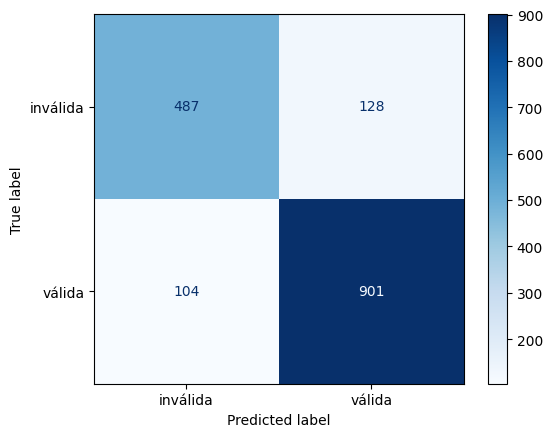

In [66]:
modelPath = "../../1. Models/Clasificador/Results1"
outputPath = "../../1. Models/Clasificador/Predictions1"

evaluateClassifier(modelPath, outputPath, mainDataDictCpy["test"])

### 2) Un entrenamiento dividido en dos fases: la primera fase un ajuste con los datos sintéticos y la segunda con los datos originales


Map: 100%|██████████| 1620/1620 [00:00<00:00, 5955.91 examples/s]


Classification Report:

              precision    recall  f1-score   support

    inválida       0.79      0.81      0.80       615
      válida       0.88      0.87      0.87      1005

    accuracy                           0.84      1620
   macro avg       0.83      0.84      0.83      1620
weighted avg       0.84      0.84      0.84      1620



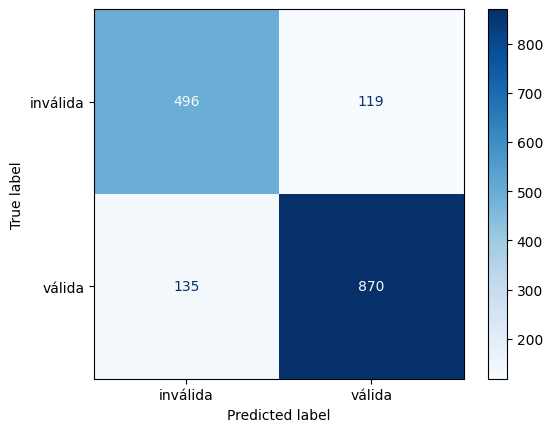

In [67]:
modelPath = "../../1. Models/Clasificador/Results2/Final"
outputPath = "../../1. Models/Clasificador/Predictions2"

evaluateClassifier(modelPath, outputPath, mainDataDictCpy["test"])

### 3) Un entrenamiento con solo datos originales

Map: 100%|██████████| 1620/1620 [00:00<00:00, 6068.15 examples/s]


Classification Report:

              precision    recall  f1-score   support

    inválida       0.76      0.75      0.75       615
      válida       0.85      0.85      0.85      1005

    accuracy                           0.81      1620
   macro avg       0.80      0.80      0.80      1620
weighted avg       0.81      0.81      0.81      1620



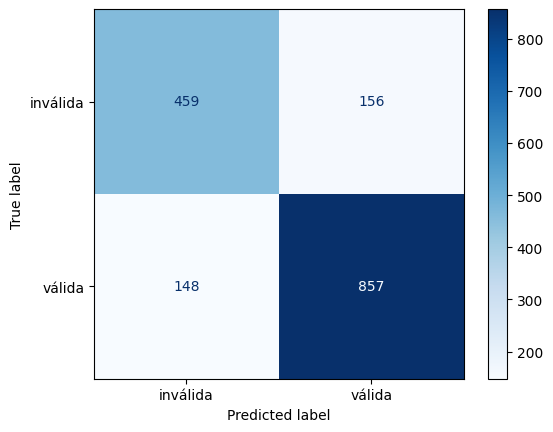

In [68]:
modelPath = "../../1. Models/Clasificador/Results3"
outputPath = "../../1. Models/Clasificador/Predictions3"

evaluateClassifier(modelPath, outputPath, mainDataDictCpy["test"])